# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model on some data using the tools available in the package. Currently, we show how to pre-process data from various dms experiments targeting Delta and Omicron spike protein homologs.

In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
import importlib
import time

# external dependencies
import pandas as pd
import numpy as onp
from tqdm.notebook import tqdm


import multidms
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**First, we'll define a few global variables.**

In [3]:
# The substitution column to use from the functional score dataframes
substitution_column = 'aa_substitutions_reference'

# The column providing which individual conditions each variant observation was derived from.
experiment_column = 'homolog_exp'

**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [6]:
fit_params = {
    # pre-processing params
    "scale_counts" : False,
    "fs_scaling_group_column" : "homolog_exp",
    "min_pre_counts" : 100,
    "pseudocount" : 0.1,
    "agg_variants" : True,
    "sample" : 5000,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "include_stop_variants" : True,
    "shift_func_score_target_nonref" : False,
    # conditions to include in fit
    "reference_condition" : "Delta-2-1",
    "conditions" : ["Delta-2-1", "Omicron_BA.1-2-1"]
}

## Pre-Proccessing

**Read in the dms data and list all available experimental conditions**

In [7]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1", "Omicron_BA.2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


**Query the conditions to be included in a fit**

In [8]:
func_score_data = func_score_data.query(
    f"{experiment_column}.isin({fit_params['conditions']})"
)
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
10,2022-06-22_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1,Lib-2_2022-06-22_thaw-1_no-antibody_control_1,Lib-2_2022-06-22_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-2_2022-06-22_thaw-...,library pre_samp...,140643,Omicron_BA.1,Omicron_BA.1-2-1


In [9]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])

  0%|          | 0/2 [00:00<?, ?it/s]

**Optionally subset the variants**

In [10]:
if fit_params["sample"]:
    func_score_df = func_score_df.sample(fit_params["sample"])

**remove all variants with string sites and stop codon wildtypes**

In [11]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_column]:
        gapped_sub_vars.append(idx)
    for sub in row[substitution_column].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

**Optionally, scale the counts**

In [12]:
# TODO re-write and make function
# def normalize_by_freq()?
if fit_params['scale_counts']:
    dfs = []
    for (h, hdf) in func_score_df.groupby(fit_params["fs_scaling_group_column"]):
        n_post_counts = sum(hdf['post_count'])
        if 'Delta' in h:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        else:
            bottleneck = 1e5
            scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
        hdf['orig_post_count'] = hdf['post_count']
        hdf['post_count'] *= scaling_factor
        hdf['post_count_wt'] *= scaling_factor
        print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

        # Recompute enrichment ratios with new counts
        hdf['pre_count_ps'] = hdf['pre_count'] + fit_params["pseudocount"]
        hdf['post_count_ps'] = hdf['post_count'] + fit_params["pseudocount"]
        hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + fit_params["pseudocount"]
        hdf['post_count_wt_ps'] = hdf['post_count_wt'] + fit_params["pseudocount"]

        total_pre_count = sum(hdf['pre_count_ps'])
        total_post_count = sum(hdf['post_count_ps'])

        hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
        hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
        hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
        hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

        hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
        hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
        hdf['e'] = hdf['var_e'] / hdf['wt_e']
        #hdf.dropna(subset=['e'], inplace=True)
        hdf['func_score'] = hdf['e'].apply(lambda x: math.log(x, 2))
        dfs.append(hdf)
    func_score_df = pd.concat(dfs)

**Drop all variants with pre-counts below a threshold.**

In [13]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
func_score_df = func_score_df[func_score_df['pre_count'] >= fit_params["min_pre_counts"]]
print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than {fit_params['min_pre_counts']} counts before selection, and were filtered out")

Of 4751 variants, 440 had fewer than 100 counts before selection, and were filtered out


**Optionally throw all variants with stop codons.**

In [14]:
# results["include_stop_variants"] = True
if not fit_params["include_stop_variants"]:
    stop_variants = [idx for idx, row in func_score_df.iterrows() if "*" in row[substitution_column]]
    func_score_df = func_score_df.drop(stop_variants)

**Optionally, clip the target functional scores**

In [15]:
if fit_params['clip_target']:
    func_score_df["func_score"] = func_score_df["func_score"].clip(*fit_params["clip_target"])

In [16]:
func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1, inplace=True)
func_score_df.rename({"homolog_exp":"condition"}, axis=1, inplace=True)

In [17]:
func_score_df.head()

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions,pre_count_threshold,homolog,replicate,condition
101002,Lib-2,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,ACGCATTCTATATATA,0.4201,0.0165,202,335,11338665,14040452,0.5,1,NaN,0,,66,Omicron_BA.1,1,Omicron_BA.1-2-1
12697,Lib-2,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,AGCAAAGTTAGTATAT,-0.0843,0.0037,1041,1216,11338665,14040452,0.5,1,S96R,1,S98R,66,Omicron_BA.1,1,Omicron_BA.1-2-1
52258,Lib-2,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CAGGAAAATACCGACT,-1.6343,0.0161,452,180,11338665,14040452,0.5,2,M1026I,1,M1029I,66,Omicron_BA.1,1,Omicron_BA.1-2-1
4278,Lib-2,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,ACTAGTTTAAATAACT,-0.1577,0.0026,1535,1704,11338665,14040452,0.5,0,NaN,0,,66,Omicron_BA.1,1,Omicron_BA.1-2-1
21104,Lib-2,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,CACTCAACAACTCAAA,-3.1157,0.0202,822,117,11338665,14040452,0.5,2,P370K P1087L,2,P373K P1090L,66,Omicron_BA.1,1,Omicron_BA.1-2-1


## `MultiDmsData`

In [85]:
help(multidms.MultiDmsData)

Help on class MultiDmsData in module multidms.data:

class MultiDmsData(builtins.object)
 |  MultiDmsData(variants_df: pandas.core.frame.DataFrame, reference: str, alphabet=('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'), collapse_identical_variants='mean', condition_colors=('#0072B2', '#009E73', '#CC79A7', '#56B4E9', '#F0E442'), letter_suffixed_sites=False)
 |  
 |  Prep data for multidms model(s),
 |  Summarize, and provide 
 |  common attributes.
 |  
 |  Note
 |  ----
 |  You can initialize a :class:`Multidms` object with a ``pd.DataFrame``
 |  with a row for each variant sampled and annotations
 |  provided in the required columns:
 |  
 |  1. `condition` - Experimental condition from
 |      which a sample measurement was obtained.
 |  2. `aa_substitutions` - Defines each variant
 |      :math:`v` as a string of substitutions (e.g., 'M3A K5G').
 |      Note that while conditions may have differing wild types
 |      at a given 

In [86]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    reference="Delta-2-1"
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1745/1745 [00:07<00:00, 247.83it/s]


In [87]:
data.site_map

,Delta-2-1,Omicron_BA.1-2-1
1016,A,A
1191,K,K
1020,A,A
1026,A,A
1078,A,A
...,...,...
792,P,P
37,Y,Y
505,Y,H
660,Y,Y


In [88]:
data.mutations[:5]

('V3F', 'V3G', 'L5E', 'L5F', 'L5G')

In [89]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1
0,V3F,V,3,F,1.0,1.0
1,V3G,V,3,G,NaN,1.0
2,L5E,L,5,E,NaN,1.0
3,L5F,L,5,F,NaN,2.0
4,L5G,L,5,G,NaN,1.0


In [90]:
data.variants_df.head() # TODO, we should probably drop allowed_variant, yes?

,condition,aa_substitutions,weight,func_score,allowed_variant,var_wrt_ref
0,Delta-2-1,,146,-0.242423,True,
1,Delta-2-1,A1016T K1191L,1,-0.481400,True,A1016T K1191L
2,Delta-2-1,A1020W,1,-0.740500,True,A1020W
3,Delta-2-1,A1026V,1,-2.772400,True,A1026V
4,Delta-2-1,A1078T,1,0.763900,True,A1078T


In [91]:
data.conditions

('Omicron_BA.1-2-1', 'Delta-2-1')

In [92]:
data.reference

'Delta-2-1'

In [93]:
data.binarymaps # this is poorly named, 'y' also exists here

{'Delta-2-1': BCOO(int8[695, 2748], nse=1639),
 'Omicron_BA.1-2-1': BCOO(int8[1745, 2748], nse=51827)}

## `MultiDmsModel`

In short the `MultiDmsModel` object initialization includes:
   1. initialize attributes
   2. initialize params depending on model composits chosen
   3. compile model composition

In [94]:
print(help(multidms.MultiDmsModel))

Help on class MultiDmsModel in module multidms.model:

class MultiDmsModel(builtins.object)
 |  MultiDmsModel(data: multidms.data.MultiDmsData, latent_model='phi', epistatic_model='identity', output_activation='identity', gamma_corrected=True, conditional_shifts=True, conditional_c=False, init_sig_range=10.0, init_sig_min=-10.0, PRNGKey=0)
 |  
 |  Represent one or more DMS experiments
 |  to obtain a predictive model for new variants,
 |  and tuned parameters that provide insight into
 |  individual mutational effects and conditional shifts
 |  of those effects on all non-reference conditions.
 |  
 |  Conceptual Overview of model
 |  ----------------------------
 |  
 |  The ``multidms`` model applies to a case where you have DMS datasets 
 |  for two or more conditions and are interested in identifying shifts 
 |  in mutational effects between conditions.
 |  To do so, the model defines one condition as a reference condition.
 |  For each mutation, the model fits one parameter that 

In [142]:
model = multidms.MultiDmsModel(
    data,
    latent_model="phi",
    epistatic_model="identity",
    output_activation="identity"
)

In [143]:
print(f"Before fitting, the loss of this model (with initial params) is {round(model.loss, 3)}")
start = time.time()
model.fit(lasso_shift=1e-5, maxiter=1)
end = time.time()
print(f"Fitting took {end - start}")
print(f"After fitting, the loss of this model (with initial params) is {round(model.loss, 3)}")

Before fitting, the loss of this model (with initial params) is 9.445
Fitting took 18.913304328918457
After fitting, the loss of this model (with initial params) is 6.836


In [144]:
model.data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1
0,V3F,V,3,F,1.0,1.0
1,V3G,V,3,G,NaN,1.0
2,L5E,L,5,E,NaN,1.0
3,L5F,L,5,F,NaN,2.0
4,L5G,L,5,G,NaN,1.0


In [145]:
model.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-2-1,times_seen_Omicron_BA.1-2-1,β,S_Omicron_BA.1-2-1,F_Omicron_BA.1-2-1,S_Delta-2-1,F_Delta-2-1
0,V3F,V,3,F,1.0,1.0,-1.399204,0.000035,3.598005,0.0,3.597969
1,V3G,V,3,G,NaN,1.0,0.774110,0.000035,5.771319,0.0,5.771284
2,L5E,L,5,E,NaN,1.0,0.900754,0.000035,5.897963,0.0,5.897928
3,L5F,L,5,F,NaN,2.0,-1.426156,0.000071,3.571089,0.0,3.571018
4,L5G,L,5,G,NaN,1.0,-1.284849,0.000035,3.712360,0.0,3.712325


In [146]:
model.data.variants_df.head()

,condition,aa_substitutions,weight,func_score,allowed_variant,var_wrt_ref
0,Delta-2-1,,146,-0.242423,True,
1,Delta-2-1,A1016T K1191L,1,-0.481400,True,A1016T K1191L
2,Delta-2-1,A1020W,1,-0.740500,True,A1020W
3,Delta-2-1,A1026V,1,-2.772400,True,A1026V
4,Delta-2-1,A1078T,1,0.763900,True,A1078T


In [147]:
model.variants_df.head()

,condition,aa_substitutions,weight,func_score,allowed_variant,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-2-1,,146,-0.242423,True,,4.997174,4.997174,-0.242423
1,Delta-2-1,A1016T K1191L,1,-0.481400,True,A1016T K1191L,6.574156,6.574156,-0.481400
2,Delta-2-1,A1020W,1,-0.740500,True,A1020W,5.457842,5.457842,-0.740500
3,Delta-2-1,A1026V,1,-2.772400,True,A1026V,6.426564,6.426564,-2.772400
4,Delta-2-1,A1078T,1,0.763900,True,A1078T,4.085991,4.085991,0.763900


**Next, we'll take a look at the plots that we can generate**

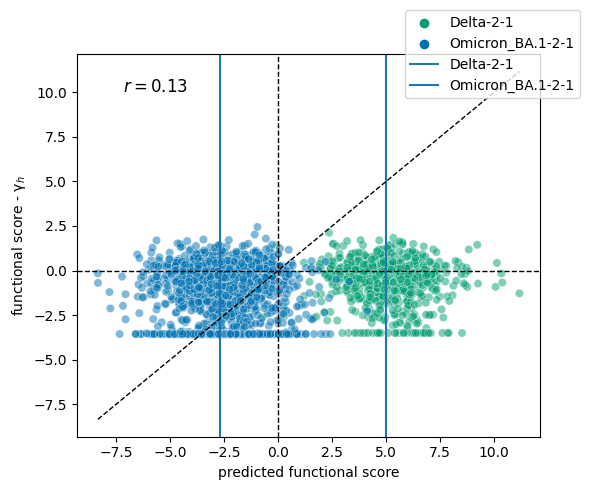

In [148]:
model.plot_pred_accuracy(show=True, alpha=0.5)

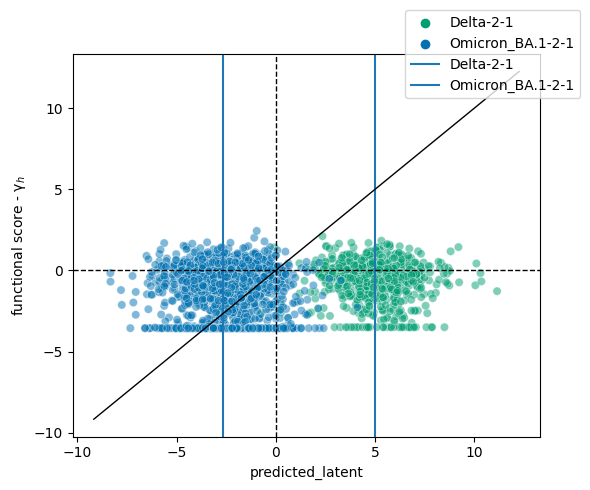

In [152]:
model.plot_epistasis(show=True, alpha=0.5)

In [120]:
sigmoid_model = multidms.MultiDmsModel(
    data,
    latent_model="phi",
    epistatic_model="sigmoid",
    output_activation="identity"
)

**The model classes share references to the same data to keep things effecient.** 

In [102]:
model.data is sigmoid_model.data

True

In [103]:
print(f"Before fitting, the loss of this model (with initial params) is {round(sigmoid_model.loss, 3)}")
sigmoid_model.fit(lasso_shift=1e-5, maxiter=1000)
print(f"After fitting, the loss of this model (with initial params) is {round(sigmoid_model.loss, 3)}")

Before fitting, the loss of this model (with initial params) is 8.985
After fitting, the loss of this model (with initial params) is 0.247


In [104]:
# for output_act in ["identity", "softplus", "gelu"]:
#     imodel = multidms.MultiDmsModel(
#         data,
#         latent_model="phi",
#         epistatic_model="sigmoid",
#         output_activation=output_act
#     )
#     imodel.fit(lasso_shift=1e-5, maxiter=1000)
#     print(f"loss w/ {output_act} output activation of this model (with initial params) is {round(imodel.loss, 3)}")